### Dataset
Dataset about ebola

In [3]:
!pip install -q rdata

In [5]:
import rdata
from jax.numpy import sqrt, exp, power, linalg, linspace
import pandas as pd
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt

np = jnp

In [6]:
parsed = rdata.parser.parse_file('ebola.rda')

# Convierte los objetos cargados a Python
dataframe = rdata.conversion.convert(parsed)

dataframe = next(iter(dataframe.values()))

dataframe['clin_signs'] = dataframe['clin_signs'].cumsum()
dataframe = dataframe.iloc[50:-20]
dataframe

,time,clin_signs,removals
51,50,1,0
52,51,1,0
53,52,1,0
54,53,1,0
55,54,1,0
...,...,...,...
168,167,291,0
169,168,291,0
170,169,291,3
171,170,291,0


## Linear Least Squares

In [36]:
def linear_least_squares(x, y, x_pred, n):
    m = len(x) - 1
    assert(n + 1 < m)

    A = [[0 for _ in range(n + 1)] for _ in range(n + 1)]
    b = [[0 for _ in range(1)] for _ in range(n + 1)]
    
    for i in range(n + 1):
        for j in range(n + 1):
            A[i][j] = sum(x[k]**(i + j) for k in range(m + 1))

    for i in range(n + 1):
        b[i] = sum(y[j]*x[j]**i for j in range(m + 1))

    P = np.linalg.solve(np.array(A), np.array(b))
    return sum(P[i]*x_pred**i for i in range(n + 1))

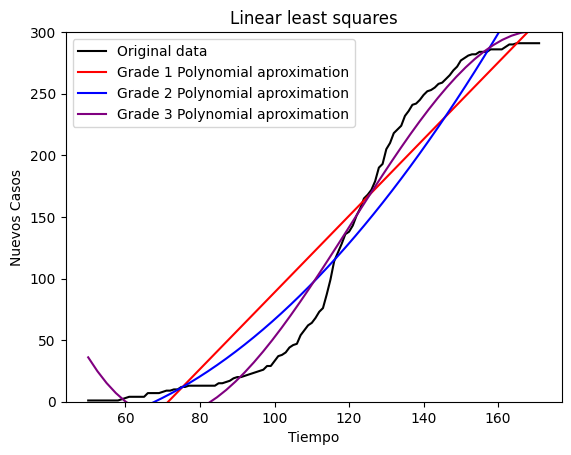

In [38]:
arr_X = jnp.array(dataframe['time'].values.astype(np.float64))
arr_Y = jnp.array(dataframe['clin_signs'].values.astype(np.float64))

x_pred = linspace(arr_X[0], arr_X[-1])
y_pred_line =  linear_least_squares(arr_X, arr_Y, x_pred, 1)
y_pred_parabola =  linear_least_squares(arr_X, arr_Y, x_pred, 2)
y_pred_cubic =  linear_least_squares(arr_X, arr_Y, x_pred, 3)

plt.plot(arr_X, arr_Y, color='black', label = "Original data")
plt.plot(x_pred, y_pred_line, color='red', label = "Grade 1 Polynomial aproximation")
plt.plot(x_pred, y_pred_parabola, color='blue', label = "Grade 2 Polynomial aproximation")
plt.plot(x_pred, y_pred_cubic, color='purple', label = "Grade 3 Polynomial aproximation")

plt.title(f"Linear least squares")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')
plt.ylim(0, 300)
plt.legend()
plt.show()

## Non-Linear Least Squares

In [7]:
def regresion(xi, ai, b0i, b1i):
  """
    Regresion Logistica

    ai -> tope de la grafica
    b0i -> intercepto con el eje x
    b1i -> pendiente con el eje x
  """
  return ai / (1 + exp(-(b0i + b1i*xi)))

def calcular_jacobiano(arr_X, params):
  """
  Calcula el Jacobiano de la función 'regresion' para una lista de valores de xi.
  """
  # Define una función que toma los parámetros (ai, b0i, b1i, ci)
  # y devuelve el valor de la función 'regresion' para un xi dado
  def regresion_para_xi(params):
      return arr_X - regresion(arr_X, *params)

  # Calcula el Jacobiano de 'regresion_para_xi' usando jacfwd
  jacobiano = jacfwd(regresion_para_xi)(params)

  return jacobiano

def vector_residuo(arr_X, arr_Y, B):
  return arr_Y - regresion(arr_X, *B)

In [8]:
def suma_de_errores_cuadrados(arr_X, arr_Y, B):
  vector = vector_residuo(arr_X, arr_Y, B)
  return sum([
      np.power(elem, 2) for elem in vector
  ])

def sanitizar_inversa(matrix, det_tol):
  if linalg.det(matrix) < det_tol:
    return linalg.pinv(matrix)

  return linalg.inv(matrix)

def Gauss_Newton(max_iter, tol, inicio, arr_X, arr_Y, det_tol):
  B = inicio
  valores_iteracion = []

  for i in range(max_iter):
    J = calcular_jacobiano(arr_X, B)
    JtJ_inv = sanitizar_inversa(np.dot(J.T, J), det_tol)
    JtJ_invJt = np.dot(JtJ_inv, J.T)

    B -= np.dot(JtJ_invJt, vector_residuo(arr_X, arr_Y, B))

    temp = suma_de_errores_cuadrados(arr_Y, arr_X, B)

    if i>1:
      if jnp.any(jnp.isnan(temp)): break
      if abs(valores_iteracion[-1] - valores_iteracion[-2]) < tol: break

    valores_iteracion.append(temp)
    print("Iteracion:", i, "\tError Cuadrado:", temp)

  return B, valores_iteracion

/Users/danielcorrea/numericalAnalysis/tarea2/repo/.venv/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Iteracion: 0 	Error Cuadrado: 1564789.2
Iteracion: 1 	Error Cuadrado: 1533394.5
Iteracion: 2 	Error Cuadrado: 1620796.9
Iteracion: 3 	Error Cuadrado: 1614413.9
Iteracion: 4 	Error Cuadrado: 1612896.1
Iteracion: 5 	Error Cuadrado: 1612674.5
Iteracion: 6 	Error Cuadrado: 1612651.5
Iteracion: 7 	Error Cuadrado: 1612649.1
Iteracion: 8 	Error Cuadrado: 1612649.2
Iteracion: 9 	Error Cuadrado: 1612649.1
Iteracion: 10 	Error Cuadrado: 1612649.1
Resuelto en 11 iteraciones
Respuesta: [ 2.9495993e+02 -1.1437317e+01  9.3812570e-02]


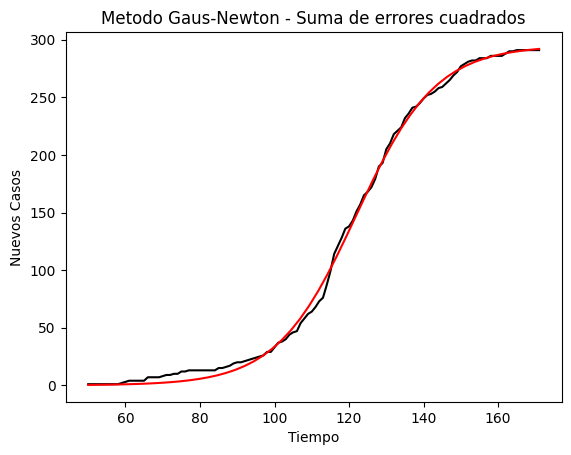

In [9]:
arr_X = jnp.array(dataframe['time'].values.astype(np.float64))
arr_Y = jnp.array(dataframe['clin_signs'].values.astype(np.float64))

iteraciones = 50
inicio = jnp.array([300, 1, 0]).astype(np.float64)
det_tol = 1e-12

B, error_gauss = Gauss_Newton(iteraciones, 1e-8, inicio, arr_X, arr_Y, det_tol)

new_X = linspace(arr_X[0], arr_X[-1])
new_Y_gauss = regresion(new_X, *B)

plt.plot(arr_X, arr_Y, color='black')
plt.plot(new_X, new_Y_gauss, color='red')
plt.title(f"Metodo Gaus-Newton - Suma de errores cuadrados")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')

print("Resuelto en", len(error_gauss), "iteraciones")
print("Respuesta:", B)
plt.show()